In [6]:
%config Completer.use_jedi = False

In [57]:
import pandas as pd
import seaborn as sns
import konlpy
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [8]:
konlpy.__version__

'0.5.1'

In [9]:
reviews = pd.read_csv('inputs/ratings_train.txt', delimiter = '\t')

In [10]:
reviews.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [11]:
test_reviews = pd.read_csv('inputs/ratings_test.txt', delimiter='\t')

## EDA

In [12]:
print('train', reviews.shape)
print('test', test_reviews.shape)

train (150000, 3)
test (50000, 3)


In [13]:
reviews.label.value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [14]:
test_reviews.label.value_counts()

1    25173
0    24827
Name: label, dtype: int64

In [15]:
reviews['length'] = reviews['document'].apply(lambda x:len(str(x)))

In [16]:
reviews.head()

,id,document,label,length
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,19
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,33
2,10265843,너무재밓었다그래서보는것을추천한다,0,17
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,29
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,61


In [17]:
test_reviews['length'] =  test_reviews['document'].apply(lambda x: len(str(x)))

/Users/sanghyub/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


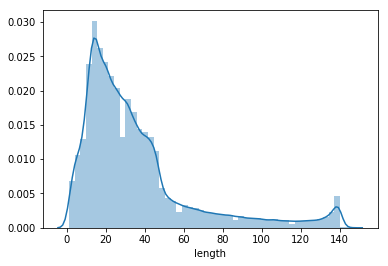

In [18]:
#length
sns.distplot(reviews.length)

/Users/sanghyub/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


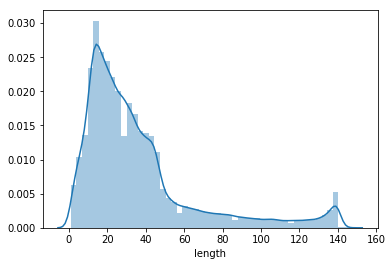

In [19]:
#length, label =0
sns.distplot(reviews[reviews.label ==0]['length'])

/Users/sanghyub/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


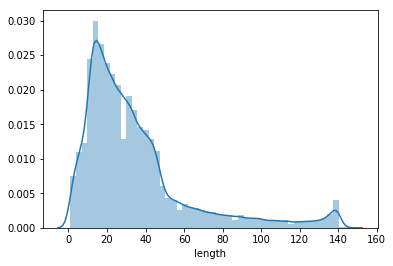

In [20]:
#length, label = 1
sns.distplot(reviews[reviews.label == 1]['length'])

/Users/sanghyub/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


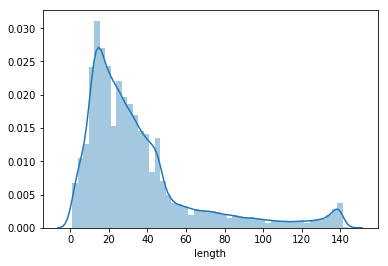

In [21]:
sns.distplot(test_reviews.length)

In [22]:
reviews.length.describe()

count    150000.000000
mean         35.203453
std          29.531983
min           1.000000
25%          16.000000
50%          27.000000
75%          42.000000
max         146.000000
Name: length, dtype: float64

In [23]:
test_reviews.length.describe()

count    50000.000000
mean        35.318320
std         29.648477
min          1.000000
25%         16.000000
50%         27.000000
75%         43.000000
max        144.000000
Name: length, dtype: float64

## TEXT preprocessing

In [24]:
okt = Okt()

In [25]:
def parse(s):
    try:
        return okt.nouns(s)
    except:
        return []

In [26]:
reviews['parsed_doc'] = reviews.document.apply(parse)

## Vectorization (Bag of Words)

In [28]:
bow_transformer = CountVectorizer(analyzer=parse).fit(reviews.document)

In [30]:
len(bow_transformer.vocabulary_)

38648

In [37]:
sample = reviews.document.iloc[333]

In [38]:
sample

'관객수가 너무 아쉬운 영화...베테랑보다도 더 류승완감독의 역작이고 더 강한악역이다'

In [41]:
sample_bow = bow_transformer.transform([sample])

In [43]:
print(sample_bow)

  (0, 404)	1
  (0, 2252)	1
  (0, 6942)	2
  (0, 9534)	1
  (0, 13901)	1
  (0, 20691)	1
  (0, 22584)	1
  (0, 22970)	1


In [46]:
reviews_bow = bow_transformer.transform([reviews.document])

In [47]:
del review_bow

In [48]:
reviews_bow.shape

(150000, 38648)

In [49]:
reviews_bow.nnz

847810

In [52]:
sparsity = reviews_bow.nnz / (reviews.shape[0]*reviews_bow.shape[1]) * 100

In [55]:
print(round(sparsity,3))

0.015


## Normalization of Vector(TF- IDF)
* tf-idf 값을 Likelihood로 이용함

In [58]:
tfidf_transform = TfidfTransformer().fit(reviews_bow)

In [60]:
print(tfidf_transform)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)


In [61]:
sample_tansform = TfidfTransformer().fit(sample_bow)

In [62]:
print(sample_bow)

  (0, 404)	1
  (0, 2252)	1
  (0, 6942)	2
  (0, 9534)	1
  (0, 13901)	1
  (0, 20691)	1
  (0, 22584)	1
  (0, 22970)	1


In [65]:
print(tfidf_transform.idf_[bow_transformer.vocabulary_['별로']])

5.30803962141


In [66]:
print(tfidf_transform.idf_[bow_transformer.vocabulary_['연기']])

4.243175184081689


In [67]:
reviews_bow.shape

(150000, 38648)

## Training

In [68]:
sentiment_detect_model = MultinomialNB().fit(reviews_bow, reviews['label'])

In [69]:
pred = sentiment_detect_model.predict(reviews_bow)

In [71]:
train_target = reviews.label.values

In [72]:
accuracy_score(pred, train_target)

0.80482

## Test

In [73]:
test_reviews_bow = bow_transformer.transform(test_reviews.document)

In [75]:
test_reviews_idf = tfidf_transform.transform(test_reviews_bow)

In [76]:
pred_test = sentiment_detect_model.predict(test_reviews_idf)

In [77]:
test_label = test_reviews['label']

In [78]:
accuracy_score(pred_test, test_label)

0.7616